## Imports

In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import sem, t
from scipy import mean

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

## Genotype & Phenotype Simulation

In [3]:
#Simulate Genotype
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    
    assert(len(G) == samples_n)
    assert(len(G[0])== loci_m)
    return G

### Set beta and envi noise

In [20]:
#Provide beta_g, e_noise and get G with genotype & Phenotype data
def simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    b_i = beta_g
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a e_j(noise) value
        e_j = np.random.normal(0, e_noise)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    G = np.append(G, Y_n, axis=1)
    return G, loci

#Provide var_g, var_e and get G with genotype & Phenotype data
def simulate_genotype_and_phenotype_var(samples_n, loci_m,var_g,var_e):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j

    G = np.append(G, Y_n, axis=1)
    return G, loci

## Random Forest Regression & SHAP 

In [5]:
def shap_RFR_tree_train(G):
    X = G[:,0:len(G[0])-1]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     forReg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50)
#     forReg.fit(x_train, y_train)
#     shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
    linReg = LinearRegression() 
    linReg.fit(x_train, y_train) 
    warnings.filterwarnings("ignore")
    explainer = shap.KernelExplainer(linReg.predict, shap.sample(x_train,100))
    shap_values = explainer.shap_values(x_test)
    return shap_values, x_train

def shap_feature_plot_RFR(shap_values, x_train):
    shap.summary_plot(shap_values, x_train, plot_type="bar")

In [6]:
# def shap_RFR_tree_train(G):
#     X = G[:,0:len(G[0])-1]
#     y = G[:,len(G[0])-1]
#     x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     model = Sequential()
#     model.add(Dense(256, activation='softmax', input_dim = len(X[0])))
#     model.add(Dropout(0.25))
#     model.add(Dense(1, activation='softmax', input_dim = 256))
#     model.add(Dropout(0.25))
#     model.compile(loss='mean_absolute_error', optimizer='SGD')
#     model.fit(x_train, y_train, epochs=10, batch_size=10, verbose = 0)
#     explainer = shap.DeepExplainer(model, x_train)
#     shap_values = explainer.shap_values(x_test)
#     return shap_values, x_train

# def shap_feature_plot_RFR(shap_values, x_train):
#     shap.summary_plot(shap_values, x_train, plot_type="bar")

## Calculate SHAP

In [7]:
# for RFR
def mean_shap_values(shap_values):
    
    shap_values = np.array(shap_values)
    avg_shap = []
    for i in range(0,len(shap_values[0])):
        shap2 = np.mean(abs(shap_values[:,i]))
        avg_shap.append(shap2)
    return avg_shap
##for NN
# def mean_shap_values(shap_values):
#     shap_values = np.array(shap_values)
#     shap_values2 = np.zeros((len(shap_values[0]),len(shap_values[0][0])))
#     shap_values2[:][:] = shap_values[0,:,:]
# #     shap_values2 = np.array(shap_values2)
#     avg_shap = []
#     for i in range(0,len(shap_values2[0])):
#         shap2 = np.mean(abs(shap_values2[:,i]))
#         avg_shap.append(shap2)
#     return avg_shap   

def max_mean_feature(shap_values):
    '''
    mean_shap = mean_shap_values(shap_values)
    return mean_shap.index(max(mean_shap)), mean_shap[mean_shap.index(max(mean_shap))]
    '''
    avg_shap = mean_shap_values(shap_values)
    temp1 = np.asarray(avg_shap)
    indices = temp1.argsort()[-2:][::-1]
    loci1,loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
    return indices[0], loci1

#TEST BEFORE USING
def max_mean_features(shap_values, no_features = 2):
    avg_shap = mean_shap_values(shap_values)
    assert(no_features <= len(avg_shap)), 'max_mean_features(), more features requested then in list'
    temp1 = np.asarray(avg_shap)
    indices = temp1.argsort()[-no_features:][::-1]
    #loci1,loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
    return indices

#G, loci = simulate_genotype_and_phenotype_set(10, 5,0.8,0.2)
#shap_values, x_train = shap_RFR_tree_train(G)
#shap_feature_plot_RFR(shap_values, x_train)
#means = max_mean_feature(shap_values)
#means
#shap_acc_RFR_set(100, 10, 0.9, 0, 100, confidence = 0.95)

## Calculating Accuracy

In [8]:
def shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise, number_trials, confidence = 0.95):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise)
        shap_values_holder, x_train = shap_RFR_tree_train(G)
        max_holder = max_mean_feature(shap_values_holder)
        if max_holder[0] == loci:
            shap_values_SNP.append(1)
        else:
            shap_values_SNP.append(0)
        counter += 1
    
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    
    n = len(shap_values_SNP)
    m = mean(shap_values_SNP)
    std_err = sem(shap_values_SNP)
    confidence_int = std_err * t.ppf((1 + confidence) / 2, n - 1)
    
    return percent, confidence_int
    

def shap_acc_RFR_var(samples_n, loci_m, var_g, var_e, number_trials):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype_var(samples_n,loci_m, var_g , var_e)
        shap_values_holder, x_train = shap_RFR_tree_train(G)
        max_holder = max_mean_feature(shap_values_holder)
        if max_holder[0] == loci:
            shap_values_SNP.append(1)
        else:
            shap_values_SNP.append(0)
        counter += 1
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    confidence_int = 1
    return percent, confidence_int

In [9]:
#samples_n = 100
#loci_m = 10
#number_trials = 100
#beta_g, e_noise = 0.9, 0.2
#percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise , number_trials, confidence = 0.95)
#print(percent)
#print(confidence_int)
    
#pickle.dump( [percent, beta_g, e_noise, confidence_int], open( "save.p", "wb" ) )

In [10]:
#favorite_color = pickle.load( open( "save.p", "rb" ) )
#print(favorite_color)

## Graphing

In [11]:
#Line Plots
def plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, e_val, number_trials, data_type = 'set'):
    
    increment = 1/range_values
    holderg = 0
    g_vals = [0]
    
    for x in range(1, range_values):
        g_vals.append(holderg + increment)
        holderg = holderg + increment
    
    shap_values_SNP = []
    
    if data_type == 'set':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)
    elif data_type == 'var':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)

            
    plt.plot(g_vals, shap_values_SNP) 
    
    if data_type == 'set':
        plt.xlabel('Value of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
    elif data_type == 'var':
        plt.xlabel('Variance of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
        
    plt.show()

In [12]:
# samples_n = 100
# loci_m = 10
# range_values = 10
# number_trials = 100
# plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.3, number_trials, data_type = 'set')
# #plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.5, number_trials, data_type = 'set')
# #plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.7, number_trials, data_type = 'set')
# #plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.9, number_trials, data_type = 'set')

In [13]:
#samples_n = 100
#loci_m = 10
#range_values = 10
#number_trials = 100
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.3, number_trials, data_type = 'set')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.5, number_trials, data_type = 'set')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.7, number_trials, data_type = 'set')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.9, number_trials, data_type = 'set')

#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.3, number_trials, data_type = 'var')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.5, number_trials, data_type = 'var')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.7, number_trials, data_type = 'var')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.9, number_trials, data_type = 'var')

In [32]:
#Line Plots
def plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials, name = 'nameme', data_type = 'set'):
    
    increment_g = 1/range_values_g
    increment_e = 1/range_values_e
    holderg = 0
    holdere = 0
    g_vals = [0]
    e_vals = [0]
    
    for x in range(1, range_values_g):
        g_vals.append(holderg + increment_g)
        holderg = holderg + increment_g
        
    for x in range(1, range_values_e):
        e_vals.append(holdere + increment_e)
        holdere = holdere + increment_e
    
    
    shap_values_SNP = []
    
    if data_type == 'set':
        for y in range(0, range_values_e):
            shap_values_SNP_holder = []
            for x in range(0,range_values_g):
                percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_vals[y], number_trials)
                shap_values_SNP_holder.append(percent)
            shap_values_SNP.append(shap_values_SNP_holder)
    elif data_type == 'var':
        for y in range(0, range_values_e):
            shap_values_SNP_holder = []
            for x in range(0,range_values_g):
                percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_vals[y], number_trials)
                shap_values_SNP_holder.append(percent)
            shap_values_SNP.append(shap_values_SNP_holder)
    print(shap_values_SNP[0])
    for x in range(0, len(shap_values_SNP)):
        e_vals[x] = str(round(e_vals[x], 2))
        plt.plot(g_vals, shap_values_SNP[x], label = e_vals[x]) 
    
    if data_type == 'set':
        plt.xlabel('Value of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.ylim([0,100])

        plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
    elif data_type == 'var':
        plt.xlabel('Variance of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.ylim([0,100])

        plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
        
    plt.legend(title = 'Environmental Noise')
#     plt.savefig(name)
    return g_vals,shap_values_SNP,e_vals

In [35]:
samples_n = 100
loci_m = 20
range_values_g = 10
range_values_e = 5
number_trials = 1



[0.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


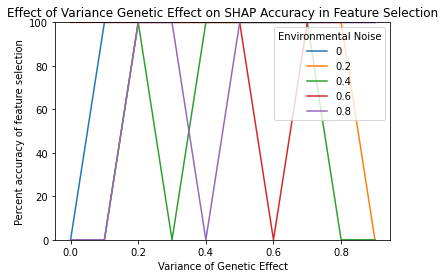

In [36]:
g_vals,shap_values_SNP,e_vals = plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials,'NN_One_Loci_fixed_var_new', data_type = 'var' )

In [ ]:
# NN_one_lociList = []
# NN_one_lociList.append(g_vals)
# NN_one_lociList.append(shap_values_SNP)
# NN_one_lociList.append(e_vals)


In [ ]:
# # import pickle
# with open('/Users/kevin/Downloads/RFR_one_lociList_var', 'wb') as fp:
#     pickle.dump(NN_one_lociList, fp)

In [ ]:
# for x in range(0, len(shap_values_SNP)):
# #     e_vals[x] = str(round(e_vals[x], 2))
#     plt.plot(g_vals, shap_values_SNP[x], label = e_vals[x]) 
    

# plt.xlabel('Variance of Genetic Effect')
# plt.ylabel('Percent accuracy of feature selection')
# plt.ylim([0,100])
# plt.title('Effect of Variance Genetic Effect on SHAP Accuracy')     
# plt.legend(title = 'Environmental Noise')
# plt.savefig('RFR_One_Loci_fixed_var')

In [ ]:
# samples_n = 1000
# loci_m = 20
# range_values_g = 10
# range_values_e = 5
# number_trials = 100
# # plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, 
# # number_trials, 'RFR_set_10000', data_type = 'set')
# plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, 
#                                    number_trials,'RFR_var_1000', data_type = 'var' )

In [ ]:
# #Bar Plots
# def plot_shap_values_RFR_bar(samples_n, loci_m, range_values, e_val, number_trials, data_type = 'set'):
    
#     increment = 1/range_values
#     holderg = 0
#     g_vals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
#     shap_values_SNP = []
#     error = []
#     if data_type == 'set':
#         for x in range(0,range_values):
#             percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_val, number_trials)
#             shap_values_SNP.append(percent)
#             error.append(confidence_int)
#             print(confidence_int)
#     elif data_type == 'var':
#         for x in range(0,range_values):
#             percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_val, number_trials)
#             shap_values_SNP.append(percent)
#             error.append(confidence_int)

#     # The x position of bars
#     barWidth = 0.7
#     r1 = np.arange(len(shap_values_SNP))
#     r2 = [x + barWidth for x in r1]
    
#     bars = g_vals
#     x_pos = np.arange(len(bars))
 
#     # Create blue bars
#     plt.bar(r1, shap_values_SNP, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=error, capsize=7)

#     # general layout
#     plt.xticks(x_pos, g_vals)
#     plt.ylabel('Percent accuracy of feature selection')

#     plt.plot(g_vals, shap_values_SNP) 
    
 
#     if data_type == 'set':
#         plt.xlabel('Value of Genetic Effect')
#         plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
#     elif data_type == 'var':
#         plt.xlabel('Variance of Genetic Effect')
#         plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
        
#     plt.show()

In [ ]:
# samples_n = 100
# loci_m = 10
# number_trials = 100
# beta_g, e_noise = 0.9, 0.2
# percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise , number_trials, confidence = 0.95)
# print(percent)
# print(confidence_int)
    
# pickle.dump( [percent, beta_g, e_noise, confidence_int], open( "save.p", "wb" ) )